$$
\begin{align*}
(\widehat{S}_{1k},...,\widehat{S}_{Ik})^T &\sim N((S_{1k}, . . . , S_{Ik})^T, \hat{\Sigma}_k )\\
    S_{ik} &\sim \delta_i P_0 + (1-\delta_i) (2M_i - 1) N(\beta_k x_i, \sigma_k^2)\\
    \beta_k &\sim N(\nu, \tau^2)\\
    M_i &\sim Bern(\phi_M)\\
    \delta_i &\sim Bern(\phi_\delta)\\
    \sigma_k^2 &\sim InvGamma(0.001, 0.001)\\
    \tau^2 &\sim InvGamma(0.001, 0.001)\\
    \nu &\sim N(0, 100)\\
\end{align*}
$$

Optionally, we can place hierarchical priors on $\phi_\delta, \phi_M$:

$$
\begin{align*}
    \phi_M &\sim Beta(u_M, v_M)\\
    \phi_\delta &\sim Beta(u_\delta, v_\delta)
\end{align*}
$$

I find that parametrizing $\beta_k$ with an unconstrained Normal improved mixing and convergence of the MCMC chains substantially. This results in multi-modal posterior distributions for $\{\beta_k\}_{k=1}^K$ and $\{M_i\}_{i=1}^I$. We can post-process to identify these parameters:

$$
\begin{align*}
    M_{ik} &= 0.5[(2M_i - 1)sign(\beta_k) + 1]\\
    \beta_k &= |\beta_k|
\end{align*}
$$

In [106]:
import numpy as np
import seaborn as sns
from scipy.stats import bernoulli, halfnorm, norm, gamma, invgamma, cauchy
import pandas as pd
import matplotlib.pyplot as plt
import math

In [107]:
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import aesara.tensor as at
import pytensor.tensor as pt
from scipy.linalg import block_diag, cholesky
import arviz as az

Running on PyMC v5.1.2


In [108]:
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

## Define the model

In [413]:
# Remove constraints that beta is non-negative so the sampler explores the space
# more efficiently and removes divergences in Hamiltonian MC
# Post-process: 
#      m_ik = ((2m_i-1)*sign(beta_k) + 1) / 2
#      beta_k = abs(beta_k)

# ate: I \times K matrix of ATE estimates
# se: I \times K matrix of s.e. of the ATE estimates
# phi_d, phi_m: Empirical Bayes estimates of phi_d, phi_m; if None places hierarchical priors on them
# TODO: update code to take se as covariance matrix inputs
def get_model_unconstrained(ate, se, x=None, phi_d=None, phi_m=None, 
                            nu=None, tau=None, 
                            alpha_d=1, beta_d=1, alpha_m=1, beta_m=1,
                            alpha_sigma=0.001, beta_sigma=0.001
                           ):
    # Set the number of NCOs
    I = ate.shape[0]
    
    # Set the number of scenarios/treatment contrasts
    K = ate.shape[1]

    # Declare the dimensions of the data and parameters. 
    # This helps with organizing the indices of the posterior samples
    coords_nco = ['nco_'+str(i) for i in range(I)]
    coords_setting = ['setting_'+str(i) for i in range(K)]
    coords = {'nco': coords_nco, 'setting': coords_setting}
    
    # Initialize a model
    model = pm.Model(coords=coords)
    with model:
        
        # State input data as shared variables. Not sure if this is neccesary, but seems to be recommended in the documentation
        Y_t = pm.MutableData('Y', ate, dims=('nco', 'setting'))
        Sigma_t = pm.MutableData('Sigma', se, dims=('nco', 'setting')) # TODO: update to include covariances
        x_t = pt.ones(I) #pm.MutableData('x', x, dims='nco') # currently fix to a vector of ones for group-mean estimation

        # Priors for unknown model parameters
        if nu is None:
            nu_t = pm.Normal('nu', mu=0, sigma=100)
        else:
            nu_t = nu
        if tau is None:
            tau_t = pm.InverseGamma('tau', 0.001, 0.001)
        else:
            tau_t = tau
        if phi_d is None: 
            phi_d_t = pm.Beta('phi_d', alpha=alpha_d, beta=beta_d)
        else:
            phi_d_t = phi_d
        if phi_m is None: 
            phi_m_t = pm.Beta('phi_m', alpha=alpha_m, beta=beta_m)
        else:
            phi_m_t = phi_m
        beta_t = pm.Normal('beta', mu=nu_t, sigma=pt.sqrt(tau_t), size=K, dims='setting')
        sigma_t = pm.InverseGamma('sigma', alpha=alpha_sigma, beta=beta_sigma, size=K, dims='setting')
        delta_t = pm.Bernoulli('delta', p=phi_d_t, size=I, dims='nco')
        m_t = pm.Bernoulli('m', p=phi_m_t, size=I, dims='nco')
        # This seems to work better than the matrix normal prior
        slap_t = pm.Normal('slap', mu=pt.outer((2*m_t-1), beta_t), sigma=pt.outer(pt.ones(I), pt.sqrt(sigma_t)), dims=('nco', 'setting'))
        mu_t = pm.Deterministic('mu', pt.outer((1-delta_t), pt.ones(K))*slap_t, dims=('nco', 'setting'))

        # Likelihood model
        # TODO: make this a truncated likelihood -2 to 2?
        Y_obs = pm.Normal('Y_obs', mu=mu_t, sigma=Sigma_t, observed=Y_t, dims=('nco', 'setting'))

        # # Compound sampling step using MH + MWG + NUTS
        # if (mh_step):
        #     step = pm.CompoundStep([
        #                             pm.BinaryGibbsMetropolis([delta_t, m_t], transit_p=.42),
        #                             pm.Metropolis([beta_t, slap_t, sigma_t, tau_t])
        #                             ])
        #     return (model, step)
    
    return model

## Simulate data

Simulate data from the following model but include 10 NCOs:

<div>
<img src="dag-1.png" width="500"/>
</div>

Since there is no observed confounder, we can estimate the average causal effects and biases using difference in means.

In [284]:
# Set random seed
np.random.seed(42)
# Set number of observations
n = 1000
# Set number of unobserved confounders
p_u = 1
# Set number of treatment groups
n_a = 3
# Set number of scenarios/treatment contrasts
K = math.comb(n_a, 2)

# Generate latent space regression coefficients of U on A
alpha_u = np.random.uniform(0.25, 0.5, p_u)  # effect of U on treatment assigment A

# Generate unobserved confounder from standard normal
U = np.random.normal(size=(n, p_u))
# Generate another dataset with 1M samples to approximate the truth
U_1m = np.random.normal(size=(1000000, p_u))

# Define the treatment groups by discretizing the latent A according to quantiles
A = np.matmul(U, alpha_u)
# Add observation noise
A = A + np.random.normal(0, 1, size=n)
A_1m = np.matmul(U_1m, alpha_u) + np.random.normal(0, 1, size=len(U_1m))
# Generate the categorical treatment A using a probit model
A_obs = np.digitize(A, np.quantile(A_1m, np.linspace(0, 1, n_a+1))[0:n_a], right=False)
A_obs_1m = np.digitize(A_1m, np.quantile(A_1m, np.linspace(0, 1, n_a+1))[0:n_a], right=False)
# Reindex to start at 0
A_obs -= min(A_obs_1m)
A_obs_1m -= min(A_obs_1m)

# Create one-hot-encoding of A_obs: n \times n_a
unique_values = np.unique(A_obs_1m)
identity_matrix = np.eye(len(unique_values))
A_encoded = identity_matrix[np.searchsorted(unique_values, A_obs)]

In [366]:
# Define number of NCOs
I = 10

# Define the effects of U on the NCOs in latent space
beta_u_low = 0.5
beta_u_high = 1
theta_u = np.random.uniform(beta_u_low, beta_u_high, size=(p_u, I+1))

# Randomly zero-out the effects
theta_u *= np.random.choice([0, 1], size=(p_u, I+1))

# Randomly shuffle the sign of the effects with probability 0.5
theta_u *= np.random.choice([-1, 1], size=(p_u, I+1))

# Generate the latent NCOs
noise_se = 0.5
N_1m = np.matmul(U_1m, theta_u) + np.random.normal(0, noise_se, size=(len(U_1m), I+1)) # use large sample of 1M observations to approx true bias
N = np.matmul(U, theta_u) + np.random.normal(0, noise_se, size=(n, I+1))

# Discretize the latent NCOs
N_obs_1m = 1*(N_1m > np.zeros(I+1))
N_obs = 1*(N > np.zeros(I+1))

# Calculate the difference in means or biases
bias_N_true = [] # based on 1M samples
bias_N = []
for i in range(n_a-1):
    for j in range(i+1, n_a):
        bias_N.append(np.mean(N_obs[A_obs == j,:], axis=0) - np.mean(N_obs[A_obs == i,:], axis=0))
        bias_N_true.append(np.mean(N_obs_1m[A_obs_1m == j,:], axis=0) - np.mean(N_obs_1m[A_obs_1m == i,:], axis=0))
bias_N = np.array(bias_N).transpose()
bias_N_true = np.array(bias_N_true).transpose()
bias_N

array([[-0.02451093, -0.048702  , -0.02419106],
       [-0.15769083, -0.20489165, -0.04720082],
       [ 0.18037975,  0.32444754,  0.1440678 ],
       [-0.18550058, -0.2570979 , -0.07159733],
       [ 0.22004219,  0.3618501 ,  0.14180791],
       [-0.01568853,  0.01559036,  0.03127889],
       [ 0.13964327,  0.2702031 ,  0.13055984],
       [ 0.0367664 ,  0.02361796, -0.01314843],
       [ 0.00841964,  0.03784953,  0.02942989],
       [-0.12502877, -0.27721161, -0.15218285],
       [ 0.02054085,  0.00677609, -0.01376477]])

In [367]:
# Define function for statistics: s.e. for the biases
def get_boostrap_bias(indices, ncos, treatment, n):
    b_ncos = ncos[indices, :]
    b_treatment = treatment[indices]
    b_bias = []
    for i in range(n-1):
        for j in range(i+1, n):
            b_bias.append(np.mean(b_ncos[b_treatment==j,:], axis=0) - np.mean(b_ncos[b_treatment==i,:], axis=0))
    return np.array(b_bias).transpose()

# Set the number of bootstrap samples
n_bootstrap = 100
# Create random sample with replacement of row indinces
b_indices = np.random.choice(range(n), size=(n_bootstrap, n), replace=True)
# Apply statistics to bootstrapped samples
b_bias = np.apply_along_axis(get_boostrap_bias, axis=1, arr=b_indices, ncos=N_obs, treatment=A_obs, n=n_a)
# Calculate s.e. of statistics in bootstrap samples
se_bias_N = np.std(b_bias, axis=0, ddof=1)
se_bias_N

array([[0.04330676, 0.03736941, 0.03644572],
       [0.04607465, 0.03798163, 0.04121718],
       [0.04224088, 0.03447954, 0.03903858],
       [0.03778372, 0.0384808 , 0.04130418],
       [0.03932125, 0.03996209, 0.03515107],
       [0.03461176, 0.04107614, 0.03905574],
       [0.04447845, 0.04070416, 0.0373576 ],
       [0.04027682, 0.03694869, 0.03640025],
       [0.03407662, 0.04116923, 0.03706246],
       [0.04365344, 0.03754716, 0.03640894],
       [0.04310028, 0.03847678, 0.03751599]])

In [368]:
# Convert matrix of biases to dataframe
data_columns = ['setting_' + str(i) for i in range(K)]
data_index = ['nco_' + str(i) for i in range(I)]
data = pd.DataFrame(bias_N[:I,], columns=data_columns)
data['nco'] = data_index
data_long = pd.melt(data,
                    id_vars=['nco'],
                    value_vars=data_columns, 
                    var_name='setting', value_name='bias')
data_long['se'] = se_bias_N[:I,].flatten('F')
data_long['true_bias'] = bias_N_true[:I,].flatten('F')
print(data_long.head(3))

     nco    setting      bias        se  true_bias
0  nco_0  setting_0 -0.024511  0.043307  -0.001164
1  nco_1  setting_0 -0.157691  0.046075  -0.138357
2  nco_2  setting_0  0.180380  0.042241   0.157359


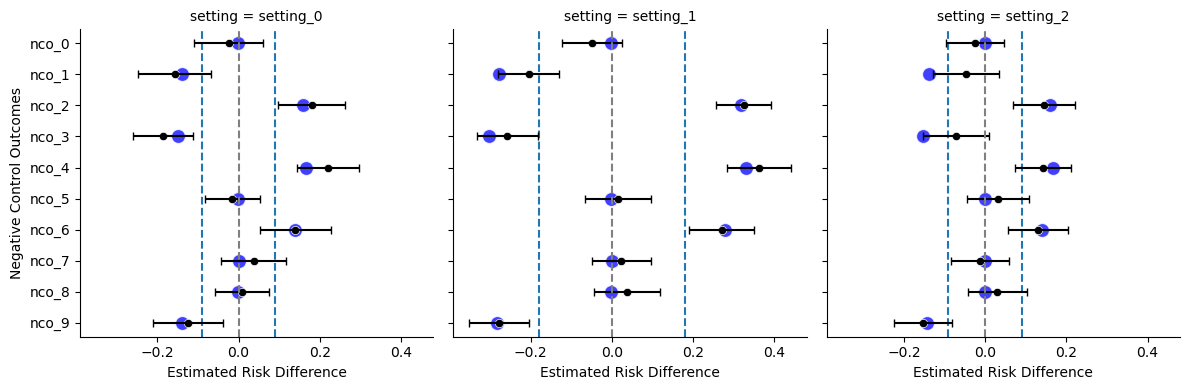

In [369]:
# Initialize a facet grid plot
g = sns.FacetGrid(data_long, col='setting', height=4, aspect=1)

# Add verticle blue line at true mean bias
axes = g.axes[0]
for ax, muk in zip(axes, np.abs(bias_N_true[:I,]).mean(axis=0)):
    ax.axvline(muk, ls='--')
    ax.axvline(-muk, ls='--')

# Create the scatter plot of true bias in blue
g.map(sns.scatterplot, 'true_bias', 'nco', alpha=0.75, color='blue', s=100)

# Create the scatter plot of the simulated data
g.map(sns.scatterplot, 'bias', 'nco', alpha=1, color='black')

# Function to add error bars
def add_error_bars(x, y, error, **kwargs):
    data = kwargs.pop("data")
    ax = plt.gca()
    for i, (_, row) in enumerate(data.iterrows()):
        ax.errorbar(row['bias'], row['nco'], xerr=1.96*row['se'], fmt='none', ecolor='black', capsize=3)

# Add error bars faceted by 'type'
g.map_dataframe(add_error_bars, 'bias', 'nco', 'se')

# Add verticle line at 0.0
g.refline(x=0.0)

# Change x axis label
g.set_axis_labels("Estimated Risk Difference", "Negative Control Outcomes")

# Show the plot
plt.show()

## Fit the model using different choices of hyperparams for the prior

In [384]:
# True scenario mean bias
true_beta = np.abs(bias_N_true[:I,]).mean(axis=0)
# Define the correct delta: all zero because U has an effect on each NCO
true_delta = 1*(theta_u[0, :I] == 0)
# Define the correct M: sign of the effect of U on NCOs
true_M = (np.sign(theta_u[:,:I]) + 1) // 2
true_M = true_M.reshape((10,))
print(true_delta.mean())
print(true_M.mean())
print(true_beta.mean())

0.4
0.3
0.11981694029669933


In [372]:
# Set parameters for fitting models
n_samples = 2000
n_tune = 20000
n_chains = 4

#### Specifying proportions (close to correct)

In [414]:
# Intialize model with phi_d and phi_m closed to the true values
model_cor = get_model_unconstrained(bias_N[:I,:], se_bias_N[:I,:], 
                                    phi_d=true_delta.mean()+0.03, 
                                    phi_m=true_M.mean()-0.03)
with model_cor:
    # MCMC sampling
    trace_cor = pm.sample(n_samples, tune=n_tune, chains=n_chains, 
                          target_accept=0.9, random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [nu, tau, beta, sigma, slap]
>BinaryGibbsMetropolis: [delta, m]


Sampling 4 chains for 20_000 tune and 2_000 draw iterations (80_000 + 8_000 draws total) took 61 seconds.
/Users/phucnguyen/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


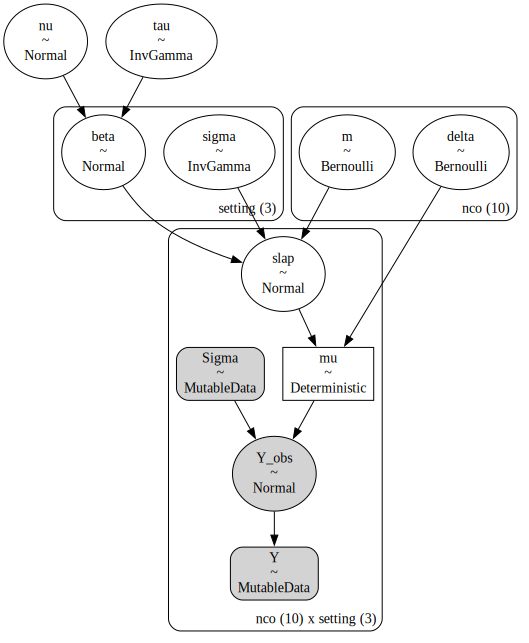

In [415]:
pm.model_to_graphviz(model_cor)

In [416]:
# Convergence diagnostics, requires multiple chains
az.summary(trace_cor, var_names=['beta', 'tau', 'sigma']).round(3)
# No convergence for beta because the posterior is bimodal (invariance in sign)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[setting_0],-0.001,0.176,-0.211,0.205,0.087,0.067,6.0,77.0,1.75
beta[setting_1],0.001,0.269,-0.306,0.307,0.134,0.102,6.0,128.0,1.74
beta[setting_2],0.002,0.128,-0.157,0.162,0.063,0.048,6.0,149.0,1.74
tau,0.006,0.010,0.000,0.018,0.000,0.000,3349.0,3372.0,1.00
sigma[setting_0],0.001,0.002,0.000,0.003,0.000,0.000,1936.0,2722.0,1.00
sigma[setting_1],0.002,0.003,0.000,0.006,0.000,0.000,1446.0,1863.0,1.01
sigma[setting_2],0.001,0.002,0.000,0.004,0.000,0.000,1850.0,2531.0,1.00


/Users/phucnguyen/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


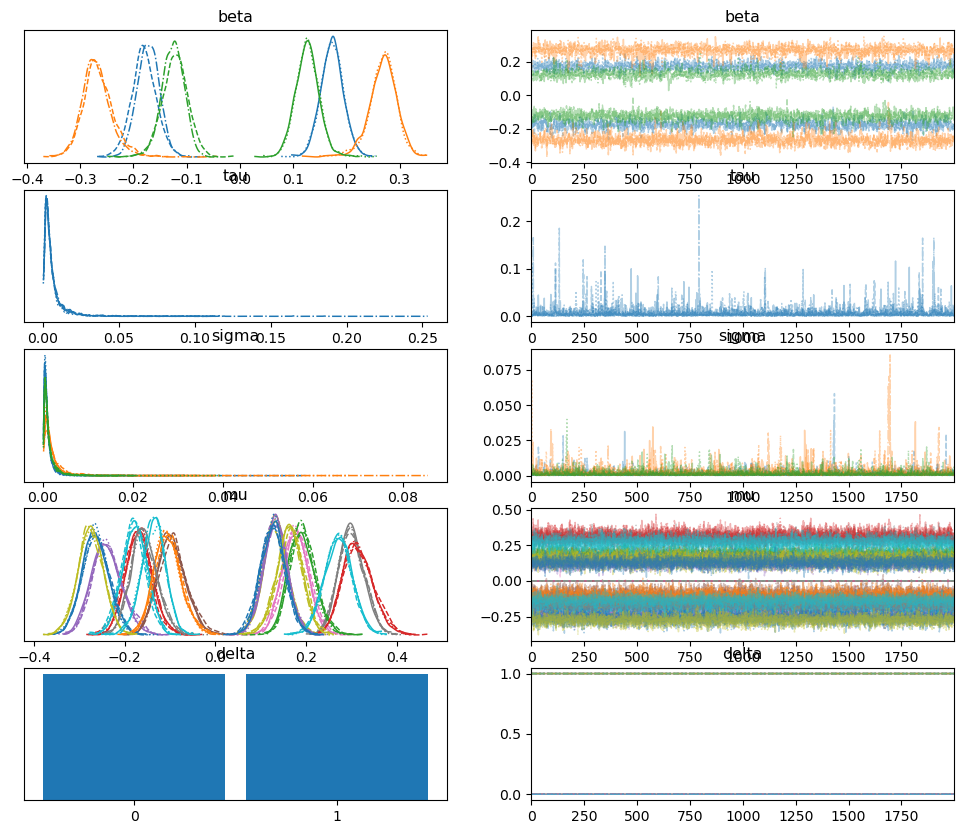

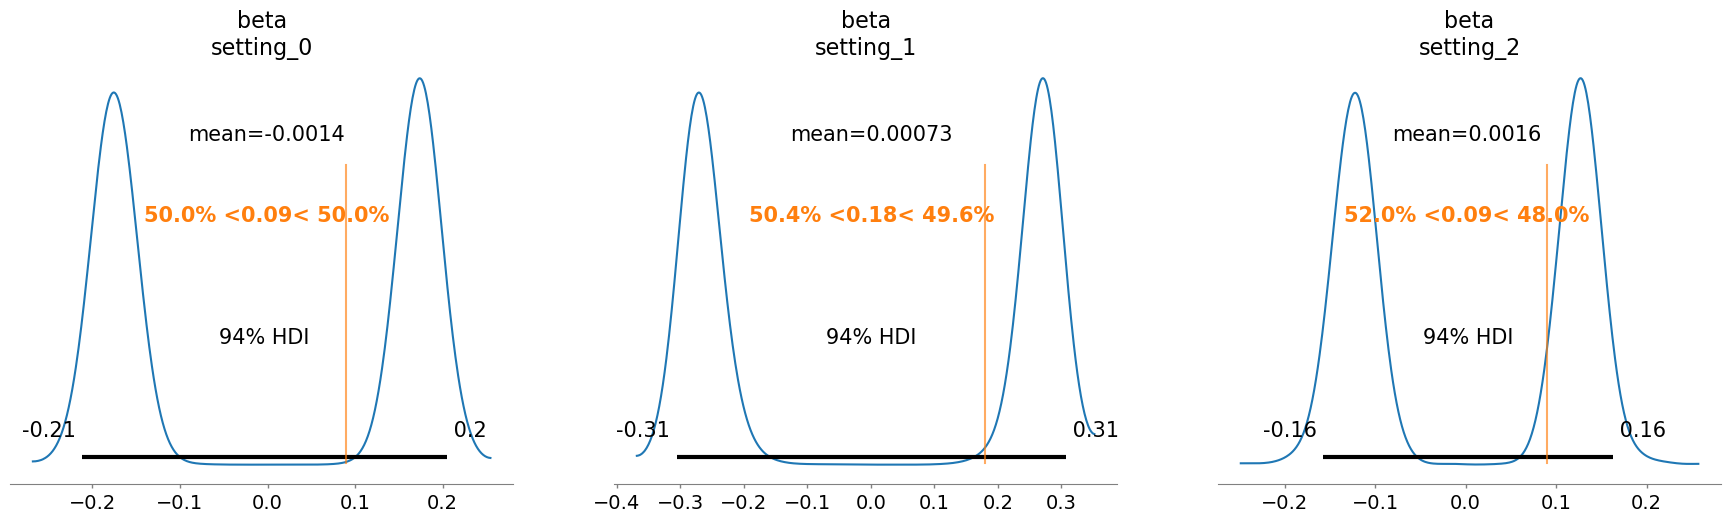

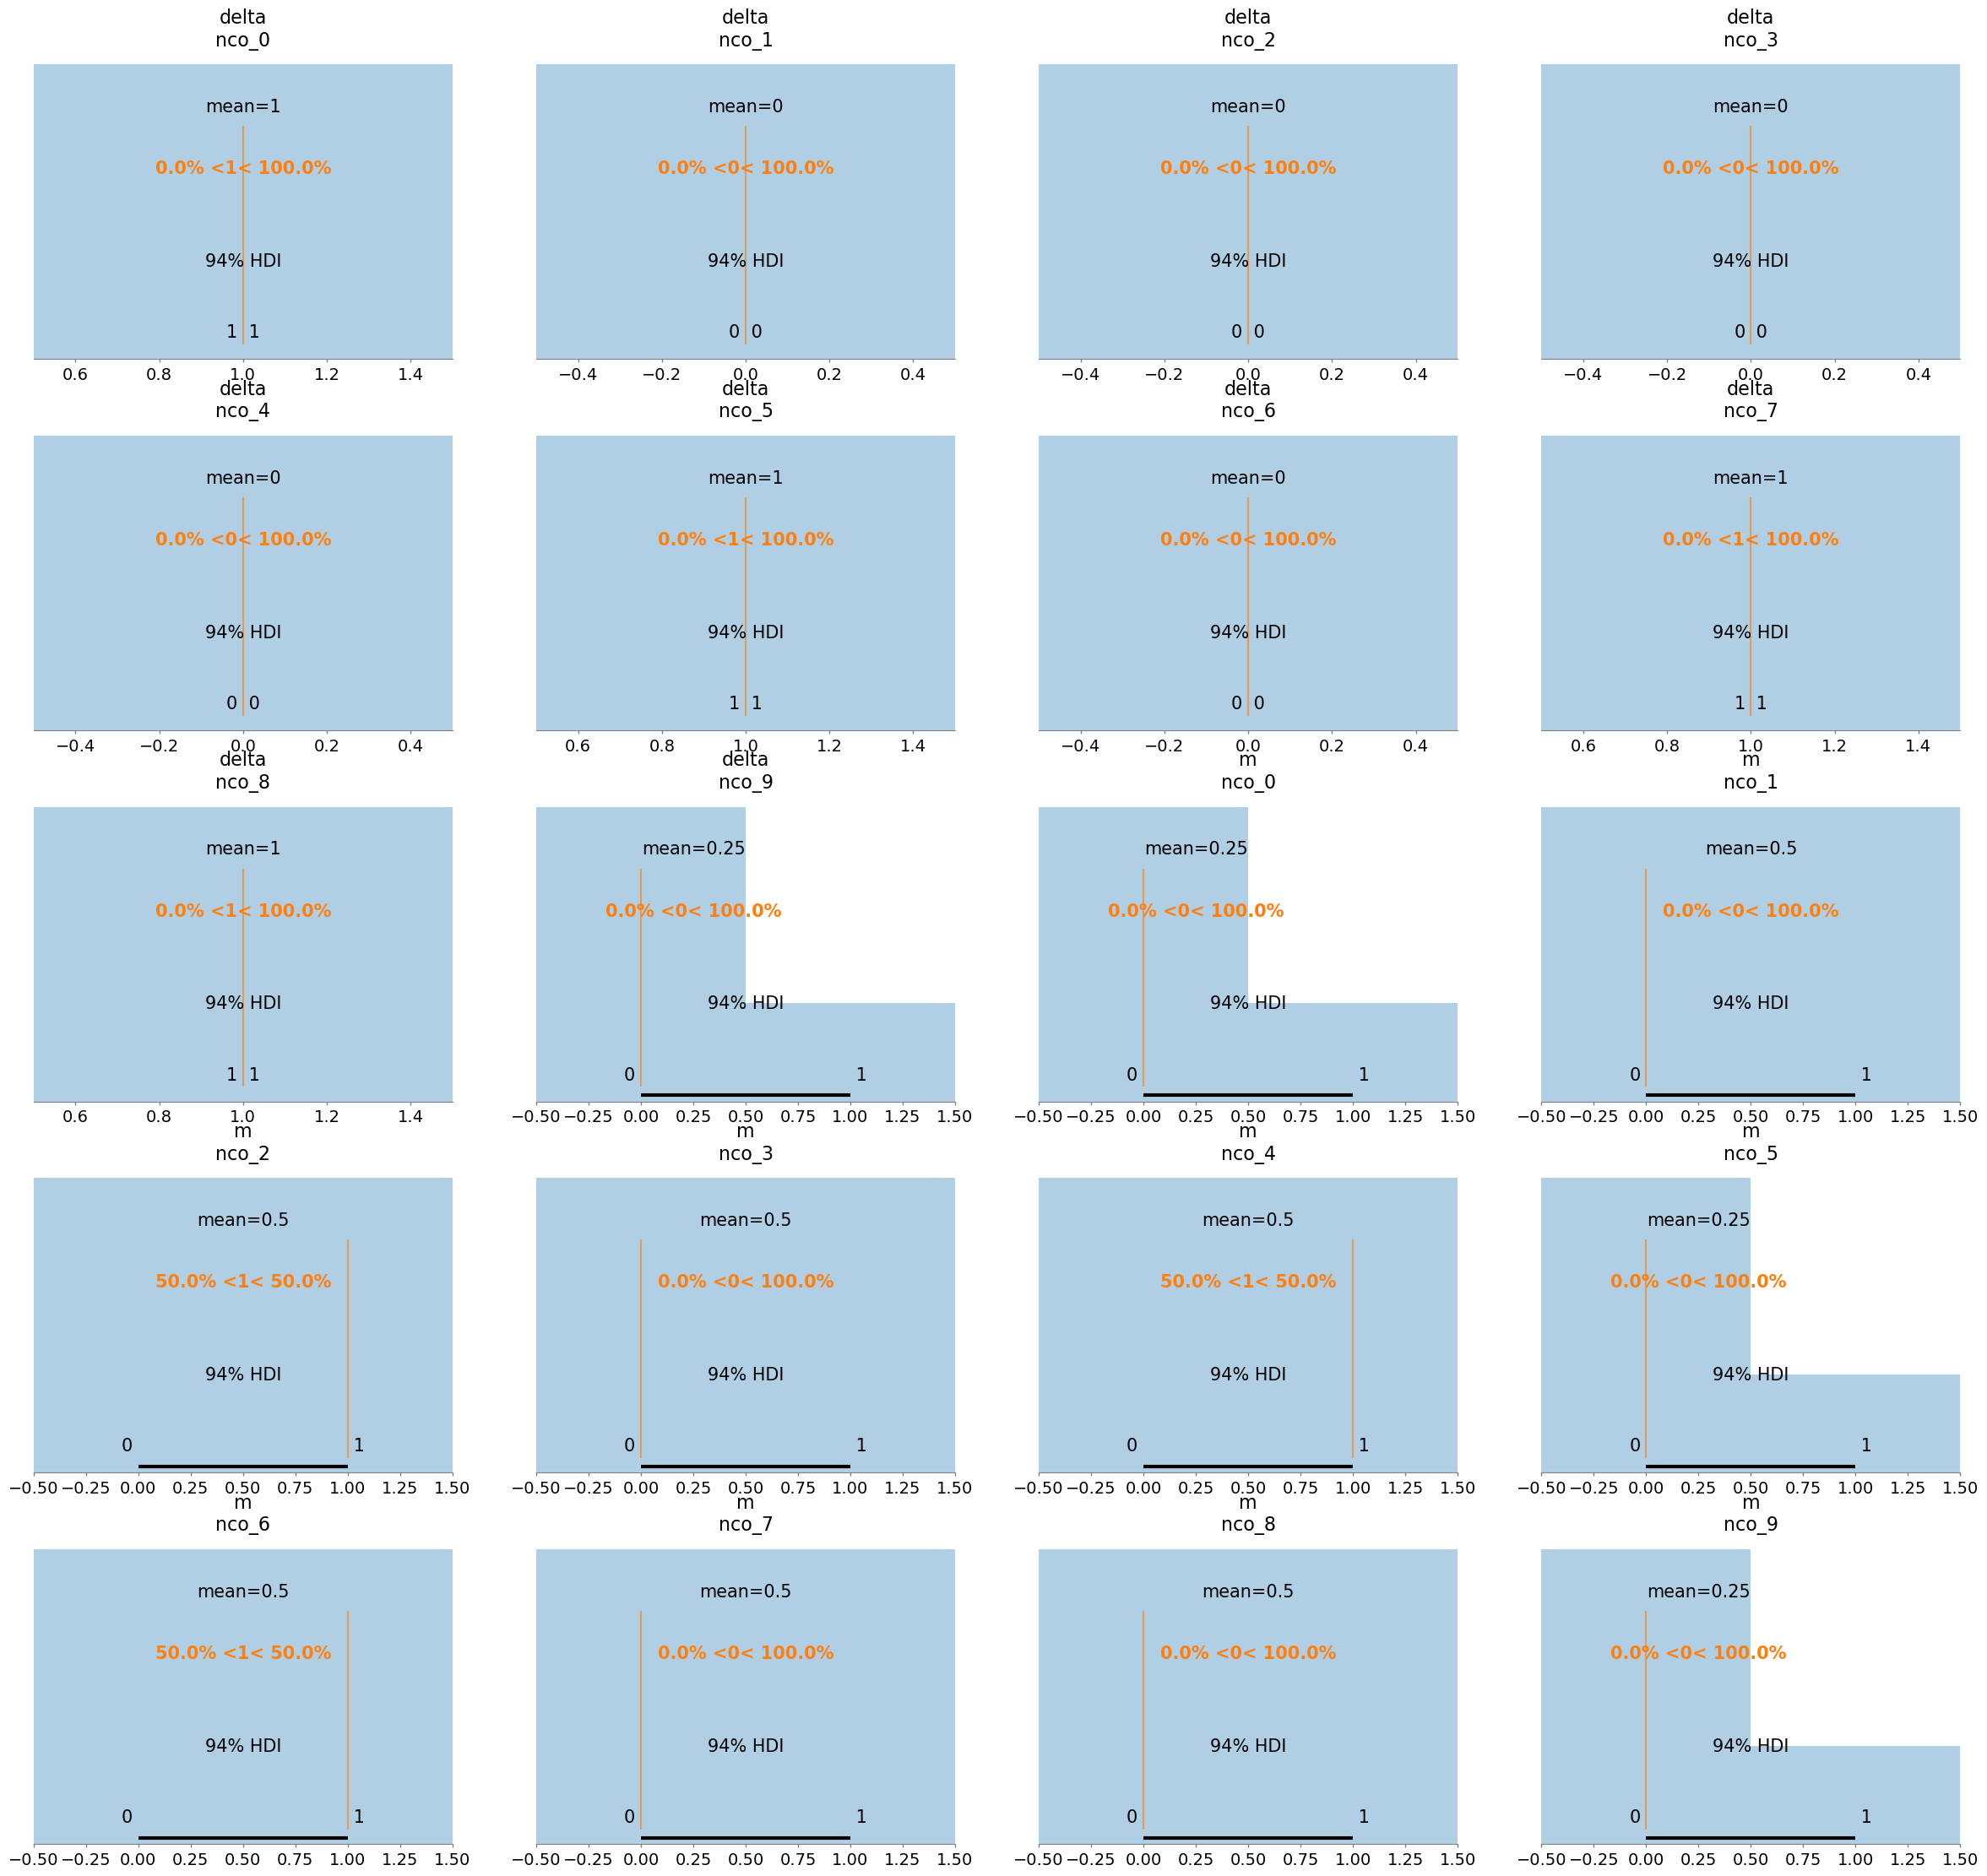

In [417]:
# Diagnose convergence by plotting posterior density and trace plots
az.plot_trace(trace_cor, var_names=["beta", "tau", "sigma", "mu", "delta"]); # expected magnitude of the bias in each treatment contrast

# Plot individual posterior density and true values written in orange
az.plot_posterior(trace_cor, var_names="beta", ref_val=true_beta.round(2).tolist());
az.plot_posterior(trace_cor, var_names=["delta", 'm'], 
                  ref_val=np.concatenate((true_delta, true_M)).astype(int).tolist());

#### Informative hierarchical priors

$$u_M = 10\phi_M, u_\delta = 10\phi_\delta$$
$$v_M = 10-u_M, v_\delta = 10-u_\delta$$

In [431]:
# model_hp = get_model_unconstrained(bias_N[:I,:], se_bias_N[:I,:], 
#                                    alpha_d=10*true_delta.mean(), beta_d=10*(1-true_delta.mean()), 
#                                    alpha_m=10*true_M.mean(), beta_m=10*(1-true_M.mean()))
model_hp = get_model_unconstrained(bias_N[:I,:], se_bias_N[:I,:])
with model_hp:
    # MCMC sampling
    trace_hp = pm.sample(n_samples, tune=n_tune, chains=n_chains, 
                         target_accept=0.9, random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [nu, tau, phi_d, phi_m, beta, sigma, slap]
>BinaryGibbsMetropolis: [delta, m]


Sampling 4 chains for 20_000 tune and 2_000 draw iterations (80_000 + 8_000 draws total) took 76 seconds.
/Users/phucnguyen/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [432]:
# Convergence diagnostics, requires multiple chains
az.summary(trace_hp, var_names=['beta', 'tau', 'sigma', 'nu', 'phi_d', 'phi_m']).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[setting_0],0.175,0.023,0.132,0.217,0.000,0.000,2345.0,3864.0,1.00
beta[setting_1],0.270,0.031,0.212,0.327,0.001,0.001,394.0,1704.0,1.03
beta[setting_2],0.130,0.023,0.084,0.172,0.002,0.001,205.0,3533.0,1.03
tau,0.007,0.021,0.000,0.019,0.001,0.000,2724.0,3457.0,1.00
sigma[setting_0],0.001,0.002,0.000,0.003,0.000,0.000,1717.0,2670.0,1.00
sigma[setting_1],0.002,0.004,0.000,0.007,0.000,0.000,510.0,1492.0,1.02
sigma[setting_2],0.001,0.002,0.000,0.004,0.000,0.000,1892.0,2912.0,1.00
nu,0.191,0.053,0.096,0.282,0.001,0.001,3384.0,3062.0,1.00
phi_d,0.457,0.145,0.194,0.728,0.020,0.015,50.0,3677.0,1.05
phi_m,0.519,0.173,0.200,0.823,0.055,0.040,10.0,59.0,1.30


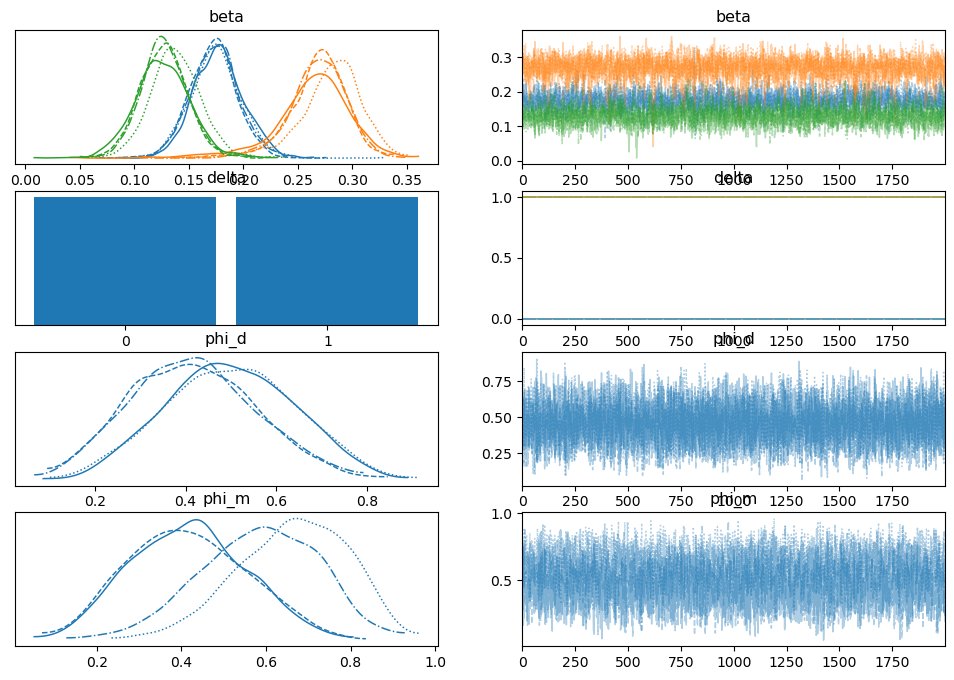

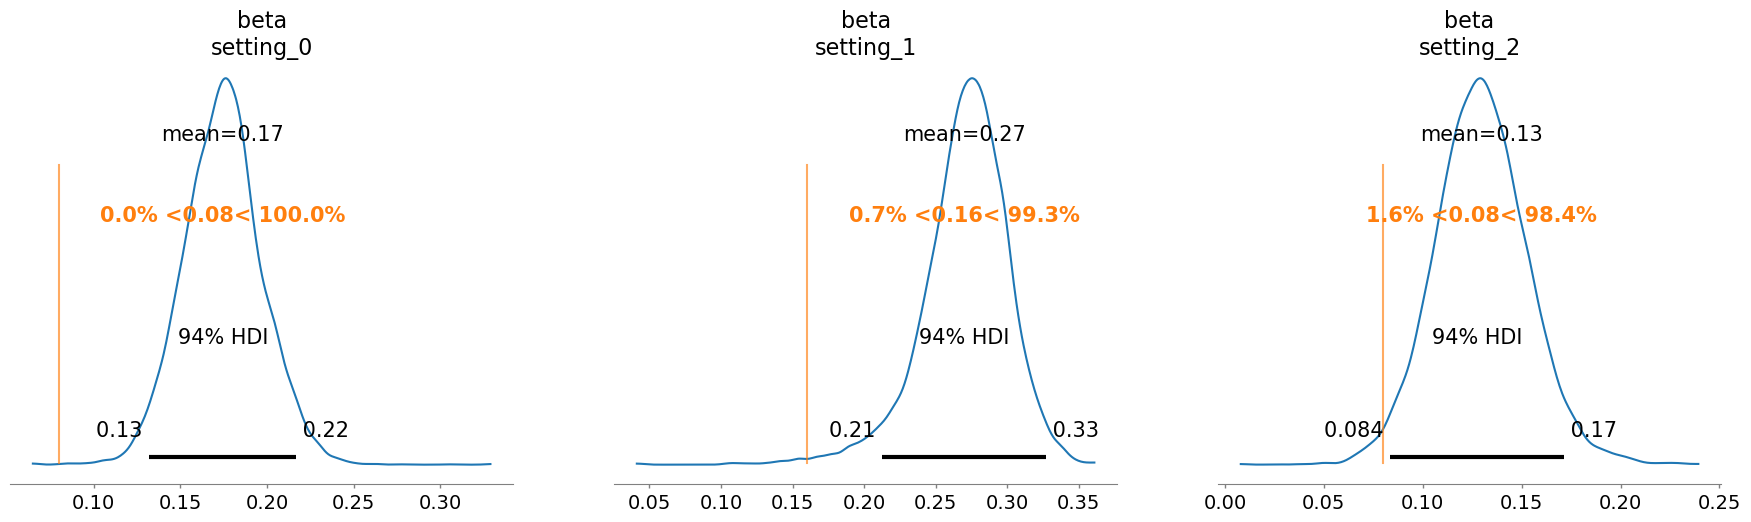

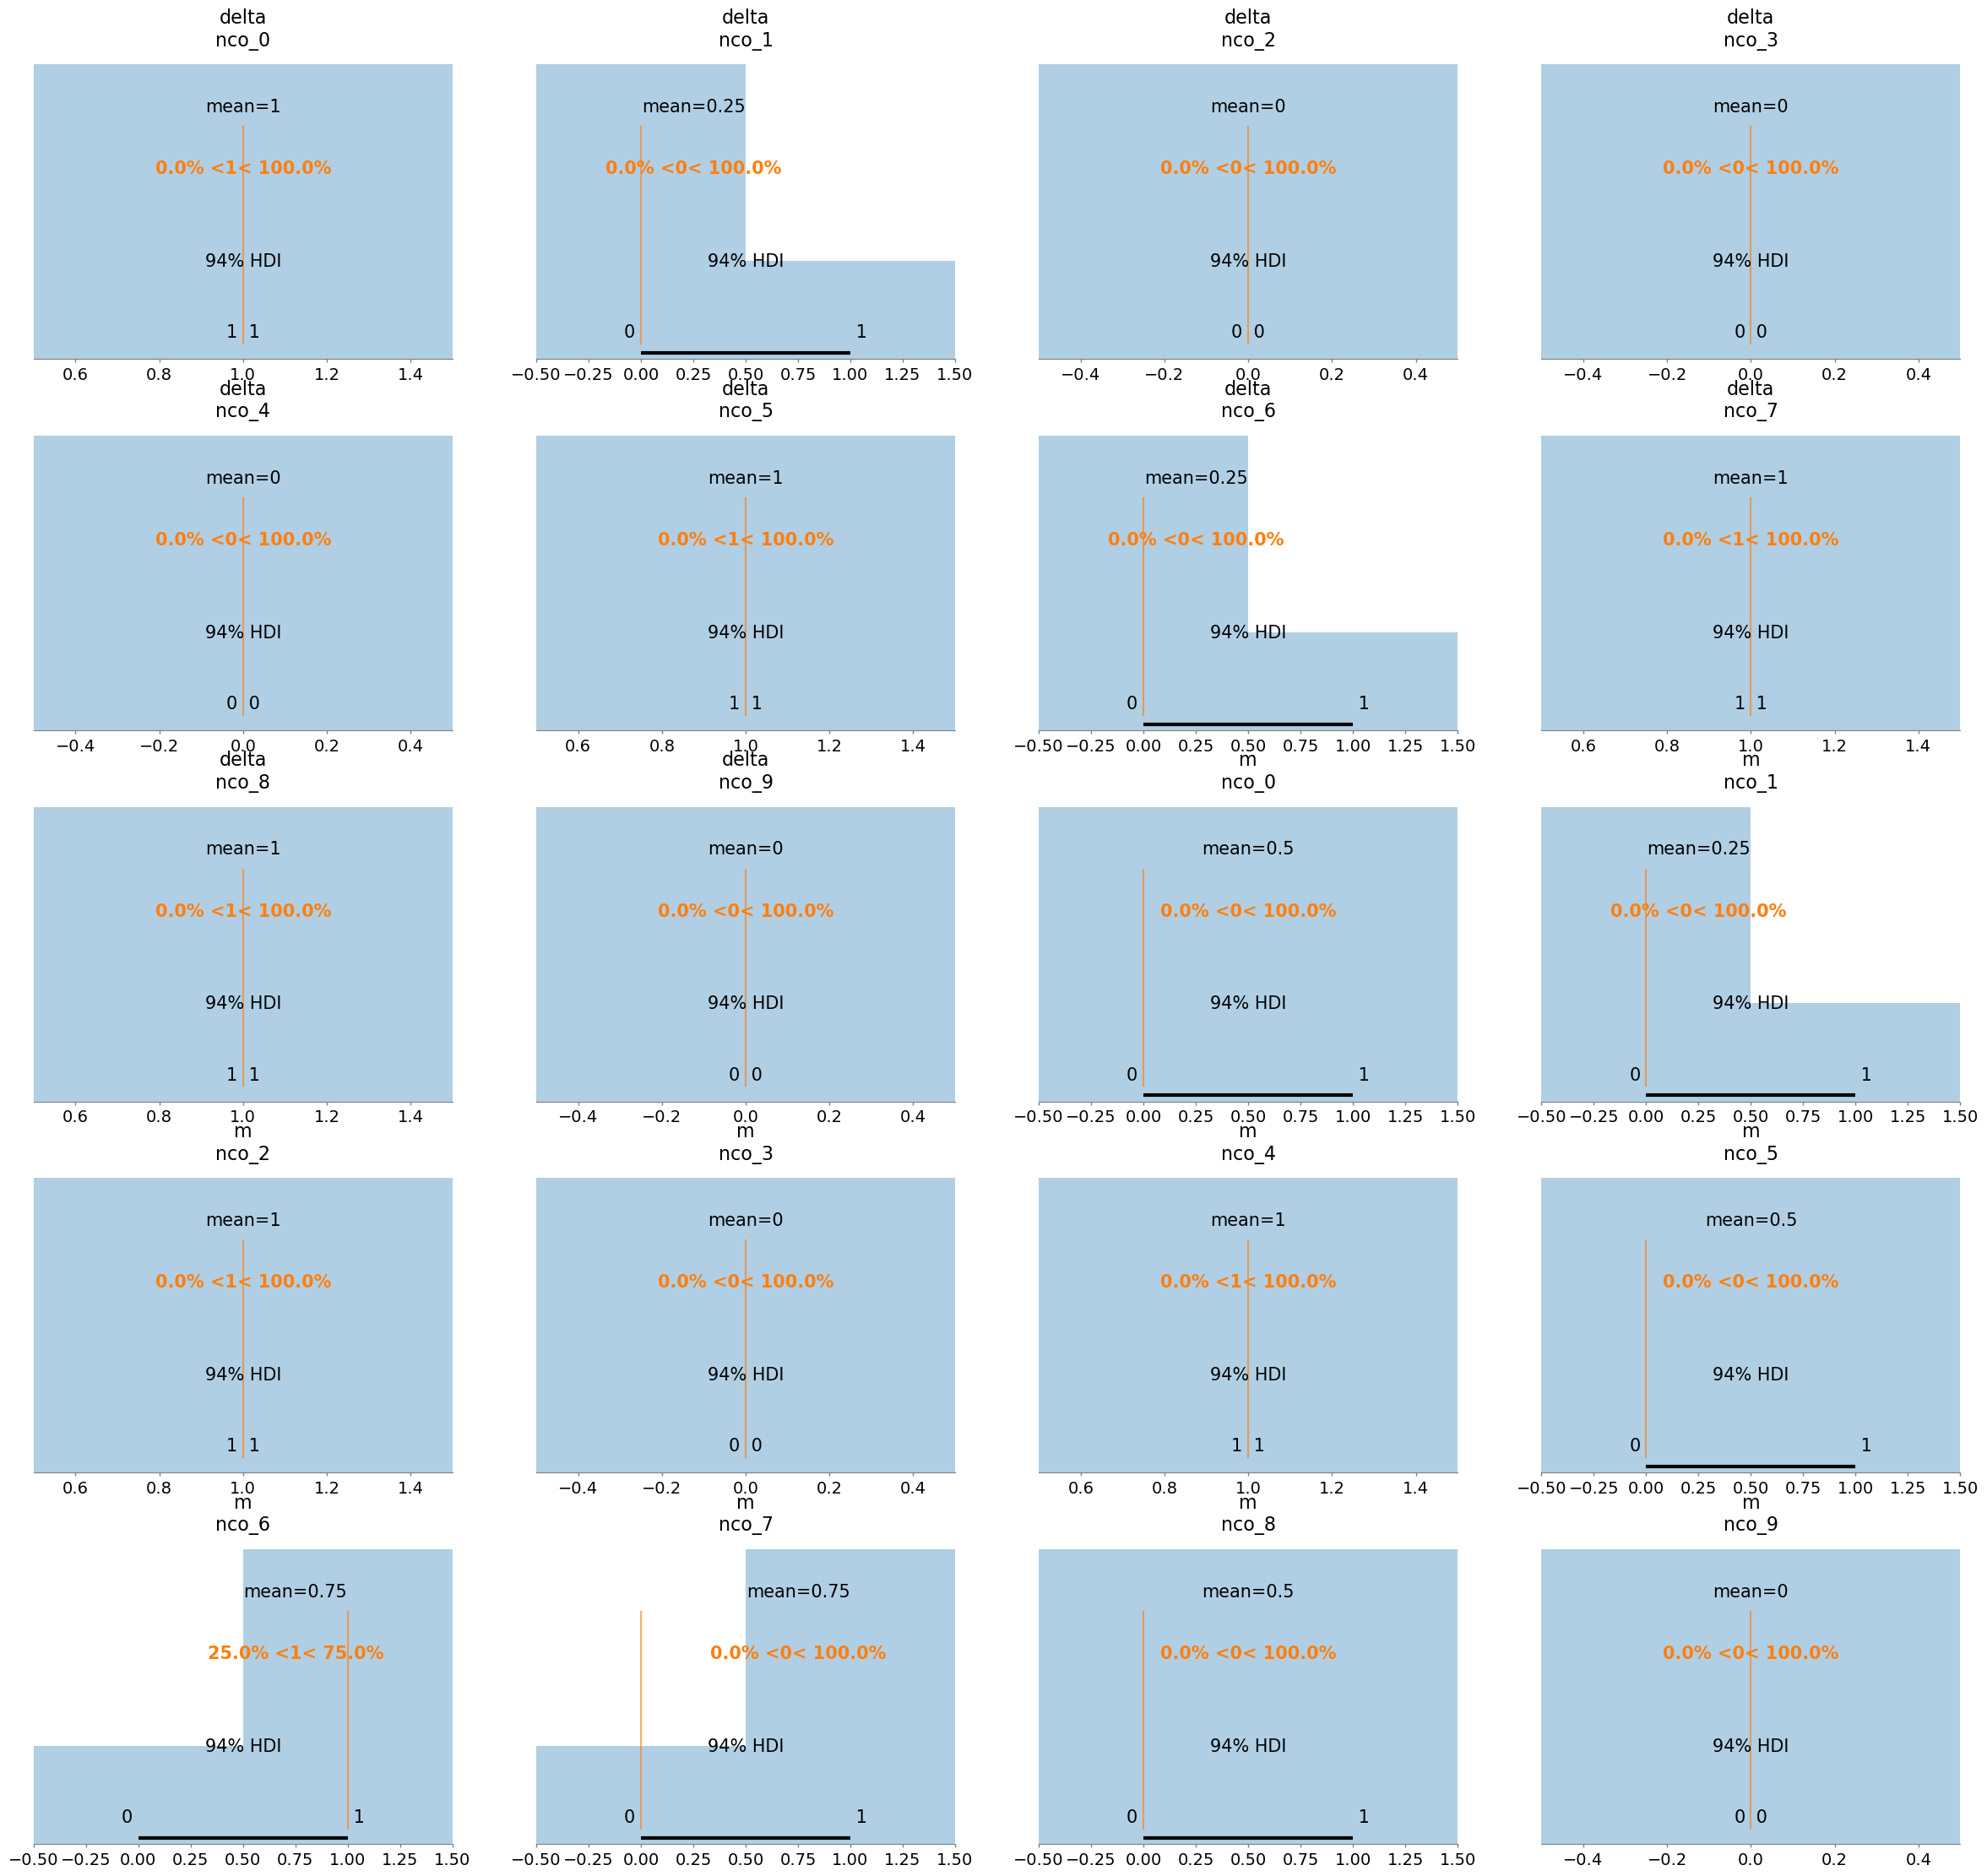

In [433]:
# Diagnose convergence by plotting posterior density and trace plots
az.plot_trace(trace_hp, var_names=["beta", 'delta', 'phi_d', 'phi_m']); # expected magnitude of the bias in each treatment contrast

# Plot individual posterior density and true values written in orange
az.plot_posterior(trace_hp, var_names="beta", ref_val=np.abs(bias_N_true).mean(axis=0).round(2).tolist());
az.plot_posterior(trace_hp, var_names=["delta", "m"], ref_val=np.concatenate((true_delta, true_M)).astype(int).tolist());

## Posterior Predictive

In [436]:
# Predict the bias in Y, assuming we expect both A and U have protective effect on Y => M=1
# For each MCMC iteration: simulate \delta_Y| \phi_d => S_Yk|\delta_Y, \beta_k, \sigma_k for all K => ATE = ATE_obs - S_Yk
num_samps = 1000
samps_hp = az.extract(trace_hp, var_names=["phi_d", 'beta', 'sigma'], num_samples=num_samps).to_dataframe()
samps_hp = samps_hp.drop(['draw', 'chain'], axis=1)
samps_hp = samps_hp.reset_index()
samps_hp.sort_values(by=['chain', 'draw', 'setting'], inplace=True)
samps_hp['delta_y'] = np.repeat(np.random.binomial(1, samps_hp.groupby(['draw', 'chain'])['phi_d'].min()), K)
samps_hp['slap_y'] = np.random.normal(np.abs(samps_hp['beta']), samps_hp['sigma'], len(samps_hp))
samps_hp['bias_posterior'] = (1-samps_hp['delta_y'])*samps_hp['slap_y']
samps_hp['bias_y_obs'] = np.tile(bias_N_true[I,:], num_samps)
print(samps_hp.head(3))


      chain  draw    setting     phi_d      beta     sigma  delta_y    slap_y  \
1257      0     5  setting_0  0.537167  0.176843  0.000328        1  0.176814   
1258      0     5  setting_1  0.537167  0.282470  0.001284        1  0.281766   
1259      0     5  setting_2  0.537167  0.116161  0.002350        1  0.121347   

      bias_posterior  bias_y_obs  
1257             0.0   -0.001194  
1258             0.0   -0.001037  
1259             0.0    0.000157  


In [437]:
# Predict the bias in Y, assuming we expect both A and U have protective effect on Y => M=1
# For each MCMC iteration: simulate \delta_Y| \phi_d => S_Yk|\delta_Y, \beta_k, \sigma_k for all K => ATE = ATE_obs - S_Yk
samps_cor = az.extract(trace_cor, var_names=['beta', 'sigma'], num_samples=num_samps).to_dataframe()
samps_cor = samps_cor.drop(['draw', 'chain'], axis=1)
samps_cor = samps_cor.reset_index()
samps_cor.sort_values(by=['chain', 'draw', 'setting'], inplace=True)
samps_cor['phi_d'] = true_delta.mean()+0.03
samps_cor['delta_y'] = np.repeat(np.random.binomial(1, samps_cor.groupby(['draw', 'chain'])['phi_d'].min()), K)
samps_cor['slap_y'] = np.random.normal(np.abs(samps_cor['beta']), samps_cor['sigma'], len(samps_cor))
samps_cor['bias_posterior'] = (1-samps_cor['delta_y'])*samps_cor['slap_y']
samps_cor['bias_y_obs'] = np.tile(bias_N_true[I,:], num_samps)
print(samps_cor.head(3))


        setting  chain  draw      beta     sigma  phi_d  delta_y    slap_y  \
830   setting_0      0     3  0.191561  0.000209   0.43        0  0.191631   
1830  setting_1      0     3  0.241997  0.001081   0.43        0  0.241504   
2830  setting_2      0     3  0.142050  0.000734   0.43        0  0.142416   

      bias_posterior  bias_y_obs  
830         0.191631   -0.001194  
1830        0.241504   -0.001037  
2830        0.142416    0.000157  


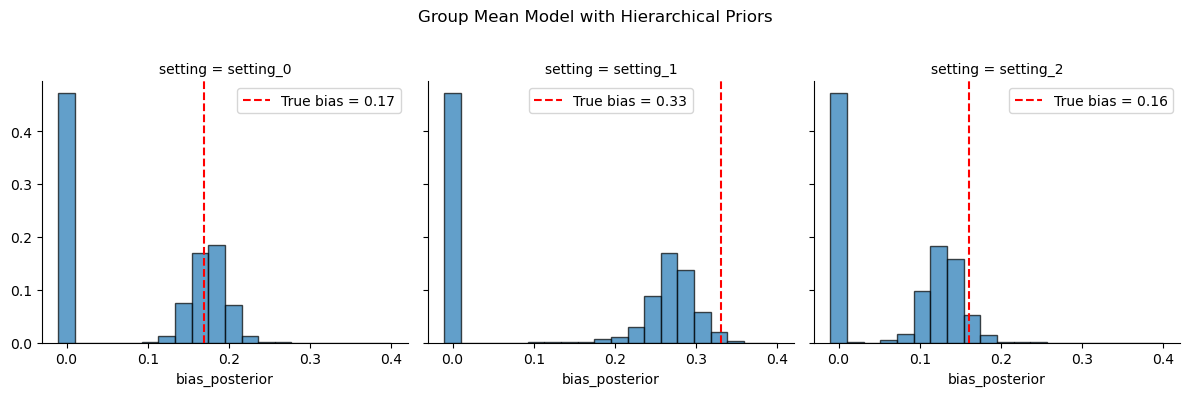

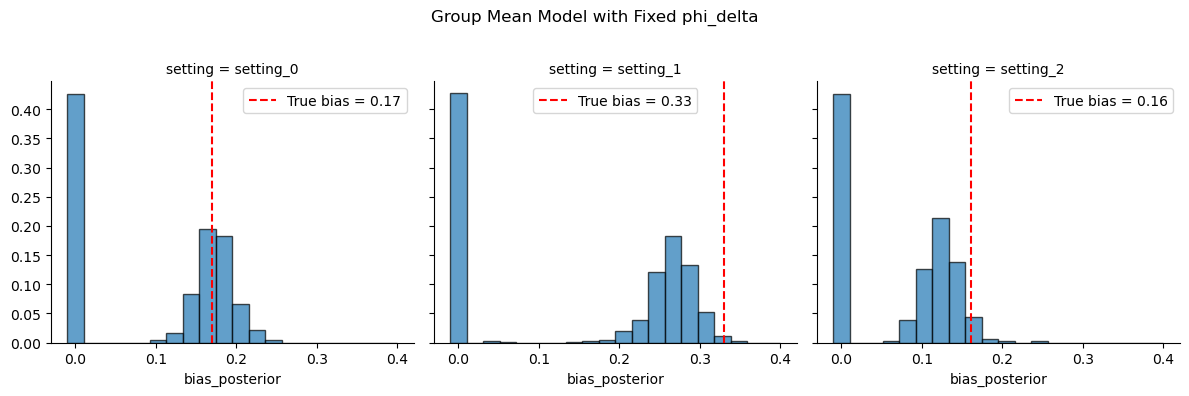

In [438]:
# Make truth a dictionary
# truth = dict(zip(data_columns, ate_Y))
# obs = dict(zip(data_columns, ate_Y_obs))
truth = dict(zip(data_columns, ate_Y_obs - ate_Y))

# Define weights so that the histogram bar at zero reflects the probability that the bias is zero
weights = np.ones(num_samps)/float(num_samps)

# Create a FacetGrid with histograms
data_list = [samps_hp, samps_cor]
plot_names = [
              'Group Mean Model with Hierarchical Priors',
              'Group Mean Model with Fixed phi_delta'
             ]
for dat, title in zip(data_list, plot_names):
    g = sns.FacetGrid(dat, col='setting', height=4, aspect=1)
    g.map(plt.hist, 'bias_posterior', edgecolor='k', bins=20, alpha=0.7, 
          weights=weights, range=(-0.01, 0.4))

    # Add vertical lines at truth values
    for ax, setting in zip(g.axes.flat, g.col_names):
        ax.axvline(truth[setting], color='red', linestyle='--', label=f'True bias = {round(truth[setting], 2)}')
    #     ax.axvline(obs[setting], color='blue', linestyle='--', label=f'Observed ATE = {round(obs[setting], 2)}')
        ax.legend()

    # Add title
    g.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
    g.fig.suptitle(title);

## Extra functions

In [109]:
# ate: I \times K matrix of ATE estimates
# se: I \times K matrix of s.e. of the ATE estimates
# phi_d, phi_m: Empirical Bayes estimates of phi_d, phi_m; if None places hierarchical priors on them
# This parametrization is slow
def get_model_slow(ate, se, x=None, phi_d=None, phi_m=None, nu=None, tau=None, alpha_d=1, beta_d=1, alpha_m=1, beta_m=1, m=None):
    # Set the number of NCOs
    I = ate.shape[0]
    
    # Set the number of scenarios/treatment contrasts
    K = ate.shape[1]

    # Declare the dimensions of the data and parameters. 
    # This helps with organizing the indices of the posterior samples
    coords_nco = ['nco_'+str(i) for i in range(I)]
    coords_setting = ['setting_'+str(i) for i in range(K)]
    coords = {'nco': coords_nco, 'setting': coords_setting}
    
    # Initialize a model
    model = pm.Model(coords=coords)
    with model:
        
        # State input data as shared variables. Not sure if this is neccesary, but seems to be recommended in the documentation
        Y_t = pm.MutableData('Y', ate, dims=('nco', 'setting'))
        Sigma_t = pm.MutableData('Sigma', se, dims=('nco', 'setting')) # TODO: update to include covariances
        x_t = pt.ones(I) #pm.MutableData('x', x, dims='nco') # currently fix to a vector of ones for group-mean estimation

        # Priors for unknown model parameters
        if nu is None:
            nu_t = pm.Normal('nu', mu=0, sigma=100)
        else:
            nu_t = nu
        if tau is None:
            tau_t = pm.HalfCauchy('tau', beta=1)
        else:
            tau_t = tau
        beta_t = pm.TruncatedNormal('beta', mu=nu_t, sigma=tau_t, lower=0, size=K, dims='setting')
        sigma_t = pm.HalfCauchy('sigma', beta=1, size=K, dims='setting')
        if phi_d is None: 
            phi_d_t = pm.Beta('phi_d', alpha=alpha_d, beta=beta_d)
        else:
            phi_d_t = phi_d
        if phi_m is None: 
            phi_m_t = pm.Beta('phi_m', alpha=alpha_m, beta=beta_m)
        else:
            phi_m_t = phi_m
        delta_t = pm.Bernoulli('delta', p=phi_d_t, size=I, dims='nco')
        if m is None:
            m_t = pm.Bernoulli('m', p=phi_m_t, size=I, dims='nco')
        else:
            m_t = pm.Data('m', m, dims='nco', mutable=False)
        # slap_t = pm.MatrixNormal('slap', mu=pt.outer(x_t, beta_t), rowcov=pt.eye(I), colcov=pt.diag(sigma_t**2), dims=('nco', 'setting'))
        # mu_t = pm.Deterministic('mu', pt.outer((1-delta_t)*(2*m_t-1), pt.ones(K))*slap_t, dims=('nco', 'setting'))
        # This seems to work better than the matrix normal prior
        slap_t = pm.Normal('slap', mu=beta_t, sigma=sigma_t, dims=('nco', 'setting'))
        mu_t = pm.Deterministic('mu', pt.outer((1-delta_t)*(2*m_t-1), pt.ones(K))*slap_t, dims=('nco', 'setting'))

        # Likelihood model
        # TODO: make this a truncated likelihood -2 to 2?
        Y_obs = pm.Normal('Y_obs', mu=mu_t, sigma=Sigma_t, observed=Y_t, dims=('nco', 'setting'))

        # # Compound sampling step using MH + MWG + NUTS
        # steps = pm.CompoundStep([
        #                         pm.BinaryGibbsMetropolis([delta_t, m_t], transit_p=.42),
        #                         pm.Metropolis([beta_t, slap_t, sigma_t, tau_t])
        #                         ])
    
    return model

In [229]:
# ate: I \times K matrix of ATE estimates
# se: I \times K matrix of s.e. of the ATE estimates
# phi_d, phi_m: Empirical Bayes estimates of phi_d, phi_m; if None places hierarchical priors on them
# TODO: update code to take se as covariance matrix inputs
def get_model_halfcauchy(ate, se, x=None, phi_d=None, phi_m=None, nu=None, tau=None, alpha_d=1, beta_d=1, alpha_m=1, beta_m=1):
    # Set the number of NCOs
    I = ate.shape[0]
    
    # Set the number of scenarios/treatment contrasts
    K = ate.shape[1]

    # Declare the dimensions of the data and parameters. 
    # This helps with organizing the indices of the posterior samples
    coords_nco = ['nco_'+str(i) for i in range(I)]
    coords_setting = ['setting_'+str(i) for i in range(K)]
    coords = {'nco': coords_nco, 'setting': coords_setting}
    
    # Initialize a model
    model = pm.Model(coords=coords)
    with model:
        
        # State input data as shared variables. Not sure if this is neccesary, but seems to be recommended in the documentation
        Y_t = pm.MutableData('Y', ate, dims=('nco', 'setting'))
        Sigma_t = pm.MutableData('Sigma', se, dims=('nco', 'setting')) # TODO: update to include covariances
        x_t = pt.ones(I) #pm.MutableData('x', x, dims='nco') # currently fix to a vector of ones for group-mean estimation

        # Priors for unknown model parameters
        if nu is None:
            nu_t = pm.Normal('nu', mu=0, sigma=100)
        else:
            nu_t = nu
        if tau is None:
            tau_t = pm.HalfCauchy('tau', beta=1)
        else:
            tau_t = tau
        if phi_d is None: 
            phi_d_t = pm.Beta('phi_d', alpha=alpha_d, beta=beta_d)
        else:
            phi_d_t = phi_d
        if phi_m is None: 
            phi_m_t = pm.Beta('phi_m', alpha=alpha_m, beta=beta_m)
        else:
            phi_m_t = phi_m
        beta_t = pm.Normal('beta', mu=nu_t, sigma=tau_t, size=K, dims='setting')
        sigma_t = pm.HalfCauchy('sigma', beta=1, size=K, dims='setting')
        delta_t = pm.Bernoulli('delta', p=phi_d_t, size=I, dims='nco')
        m_t = pm.Bernoulli('m', p=phi_m_t, size=I, dims='nco')
        # This seems to work better than the matrix normal prior
        slap_t = pm.Normal('slap', mu=pt.outer((2*m_t-1), beta_t), sigma=pt.outer(pt.ones(I), sigma_t), dims=('nco', 'setting'))
        mu_t = pm.Deterministic('mu', pt.outer((1-delta_t), pt.ones(K))*slap_t, dims=('nco', 'setting'))

        # Likelihood model
        # TODO: make this a truncated likelihood -2 to 2?
        Y_obs = pm.Normal('Y_obs', mu=mu_t, sigma=Sigma_t, observed=Y_t, dims=('nco', 'setting'))

        # # Compound sampling step using MH + MWG + NUTS
        # if (mh_step):
        #     step = pm.CompoundStep([
        #                             pm.BinaryGibbsMetropolis([delta_t, m_t], transit_p=.42),
        #                             pm.Metropolis([beta_t, slap_t, sigma_t, tau_t])
        #                             ])
        #     return (model, step)
    
    return model

In [314]:
# Generate effects of U on Y on the same scale as the effects of U on the NCOs
beta_u = np.random.uniform(beta_u_low, beta_u_high, p_u)

# Genreate treatment effects of all treatment groups in latent continuous space for Y
beta_a = np.zeros(n_a)
# beta_a = np.random.uniform(1.5, 3, n_a) #np.linspace(0, 1, n_a) #why does bias become smaller when effects are larger?

# Generate counterfactual latent Y under each treatment group
Y_counterfactuals = np.empty((n, n_a))
for i in range(n_a):
    # Create one-hot-encoding of treatment matrix when everyone receives treatment i
    treat_tmp = np.zeros((n, n_a))
    treat_tmp[:, i] = 1

    # Genrate latent Y from a normal distribution
    Y_counterfactuals[:, i] = np.matmul(np.column_stack((U, treat_tmp)),
                                        np.concatenate((beta_u, beta_a))) + np.random.normal(0, noise_se, size=n)

# Discretize the latent Y
Y_counterfactuals_binary = 1*(Y_counterfactuals > np.zeros(n_a))
# Get observed binary Y
Y_obs = 1*(Y_counterfactuals > np.zeros(n_a))
Y_obs = np.sum(Y_obs * A_encoded, axis=1)

# Calculate causal effects using difference in means
ate_Y = []  # true causal effects
ate_Y_obs = []  # biased causal effects
for i in range(n_a-1):
    for j in range(i+1, n_a):
        # Calculate risk difference between treatment group j - treatment group i
        ate_Y.append(
            np.mean(Y_counterfactuals_binary[:, j] - Y_counterfactuals_binary[:, i]))
        ate_Y_obs.append(
            np.mean(Y_obs[A_obs == j]) - np.mean(Y_obs[A_obs == i]))
# Convert to numpy array for easier usage later
ate_Y = np.array(ate_Y)
ate_Y_obs = np.array(ate_Y_obs)
print(ate_Y)
print(ate_Y_obs)
print(ate_Y_obs - ate_Y)

[ 0.014  0.006 -0.008]
[0.1835443  0.33608668 0.15254237]
[0.1695443  0.33008668 0.16054237]


#### Specifying proportions (close to correct) with HalfCauchy priors on the variances

In [326]:
model_in = get_model_halfcauchy(bias_N, se_bias_N, 
                                phi_d=true_delta.mean()+0.1, 
                                phi_m=true_M.mean()-0.1)
with model_in:
    trace_in = pm.sample(n_samples, tune=n_tune, chains=n_chains, 
                         target_accept=0.9, random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [nu, tau, beta, sigma, slap]
>BinaryGibbsMetropolis: [delta, m]


Sampling 4 chains for 20_000 tune and 2_000 draw iterations (80_000 + 8_000 draws total) took 180 seconds.
/Users/phucnguyen/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1034 divergences after tuning. Increase `target_accept` or reparameterize.


In [327]:
# Convergence diagnostics, requires multiple chains
az.summary(trace_in, var_names=['beta', 'tau', 'sigma', 'nu']).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[setting_0],0.000,0.181,-0.204,0.200,0.090,0.069,6.0,93.0,1.76
beta[setting_1],0.001,0.300,-0.321,0.318,0.149,0.114,6.0,71.0,1.75
beta[setting_2],0.002,0.122,-0.142,0.142,0.061,0.046,6.0,98.0,1.75
tau,0.251,0.281,0.037,0.605,0.011,0.008,212.0,999.0,1.03
sigma[setting_0],0.015,0.013,0.001,0.037,0.002,0.001,22.0,13.0,1.13
sigma[setting_1],0.017,0.014,0.001,0.042,0.001,0.001,84.0,91.0,1.05
sigma[setting_2],0.013,0.011,0.001,0.033,0.001,0.001,104.0,279.0,1.04
nu,-0.002,0.269,-0.438,0.415,0.099,0.073,8.0,601.0,1.46


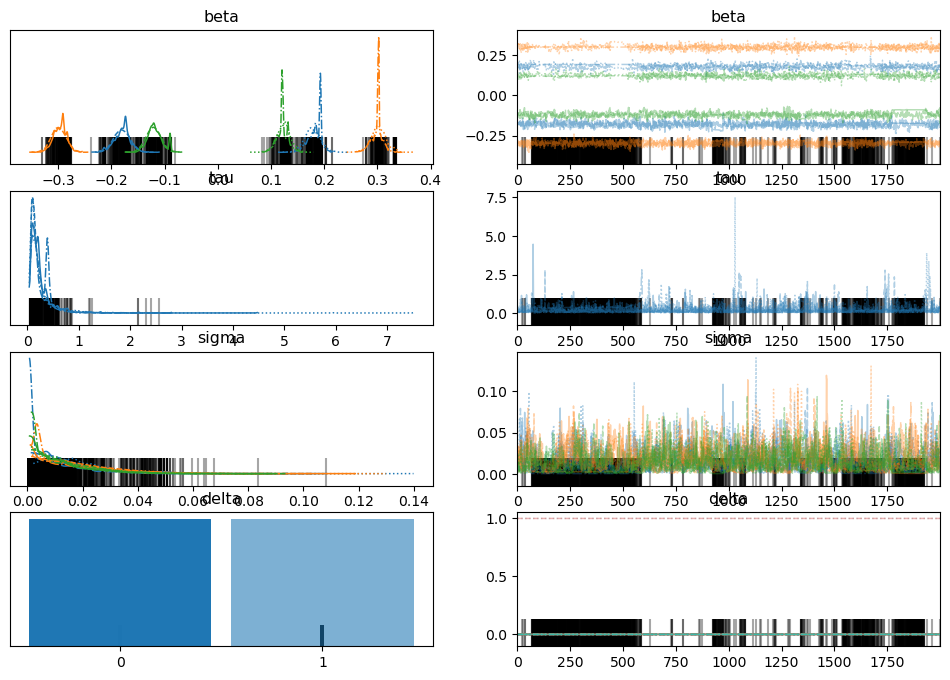

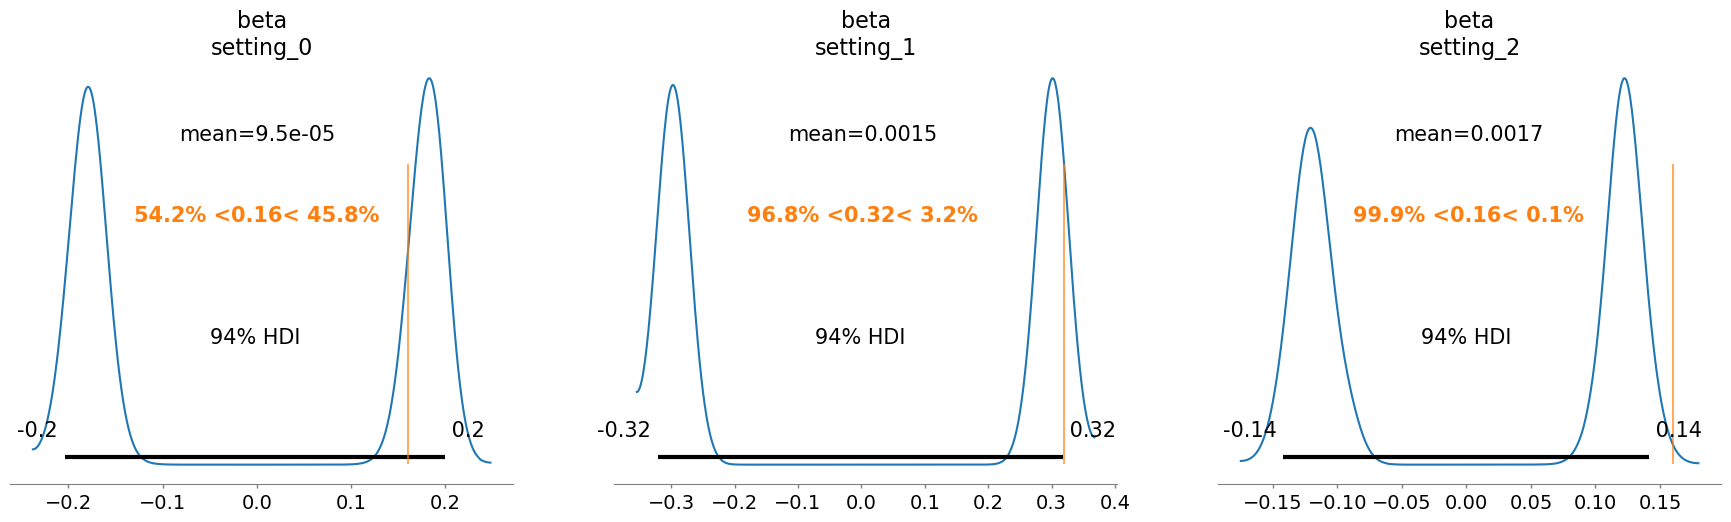

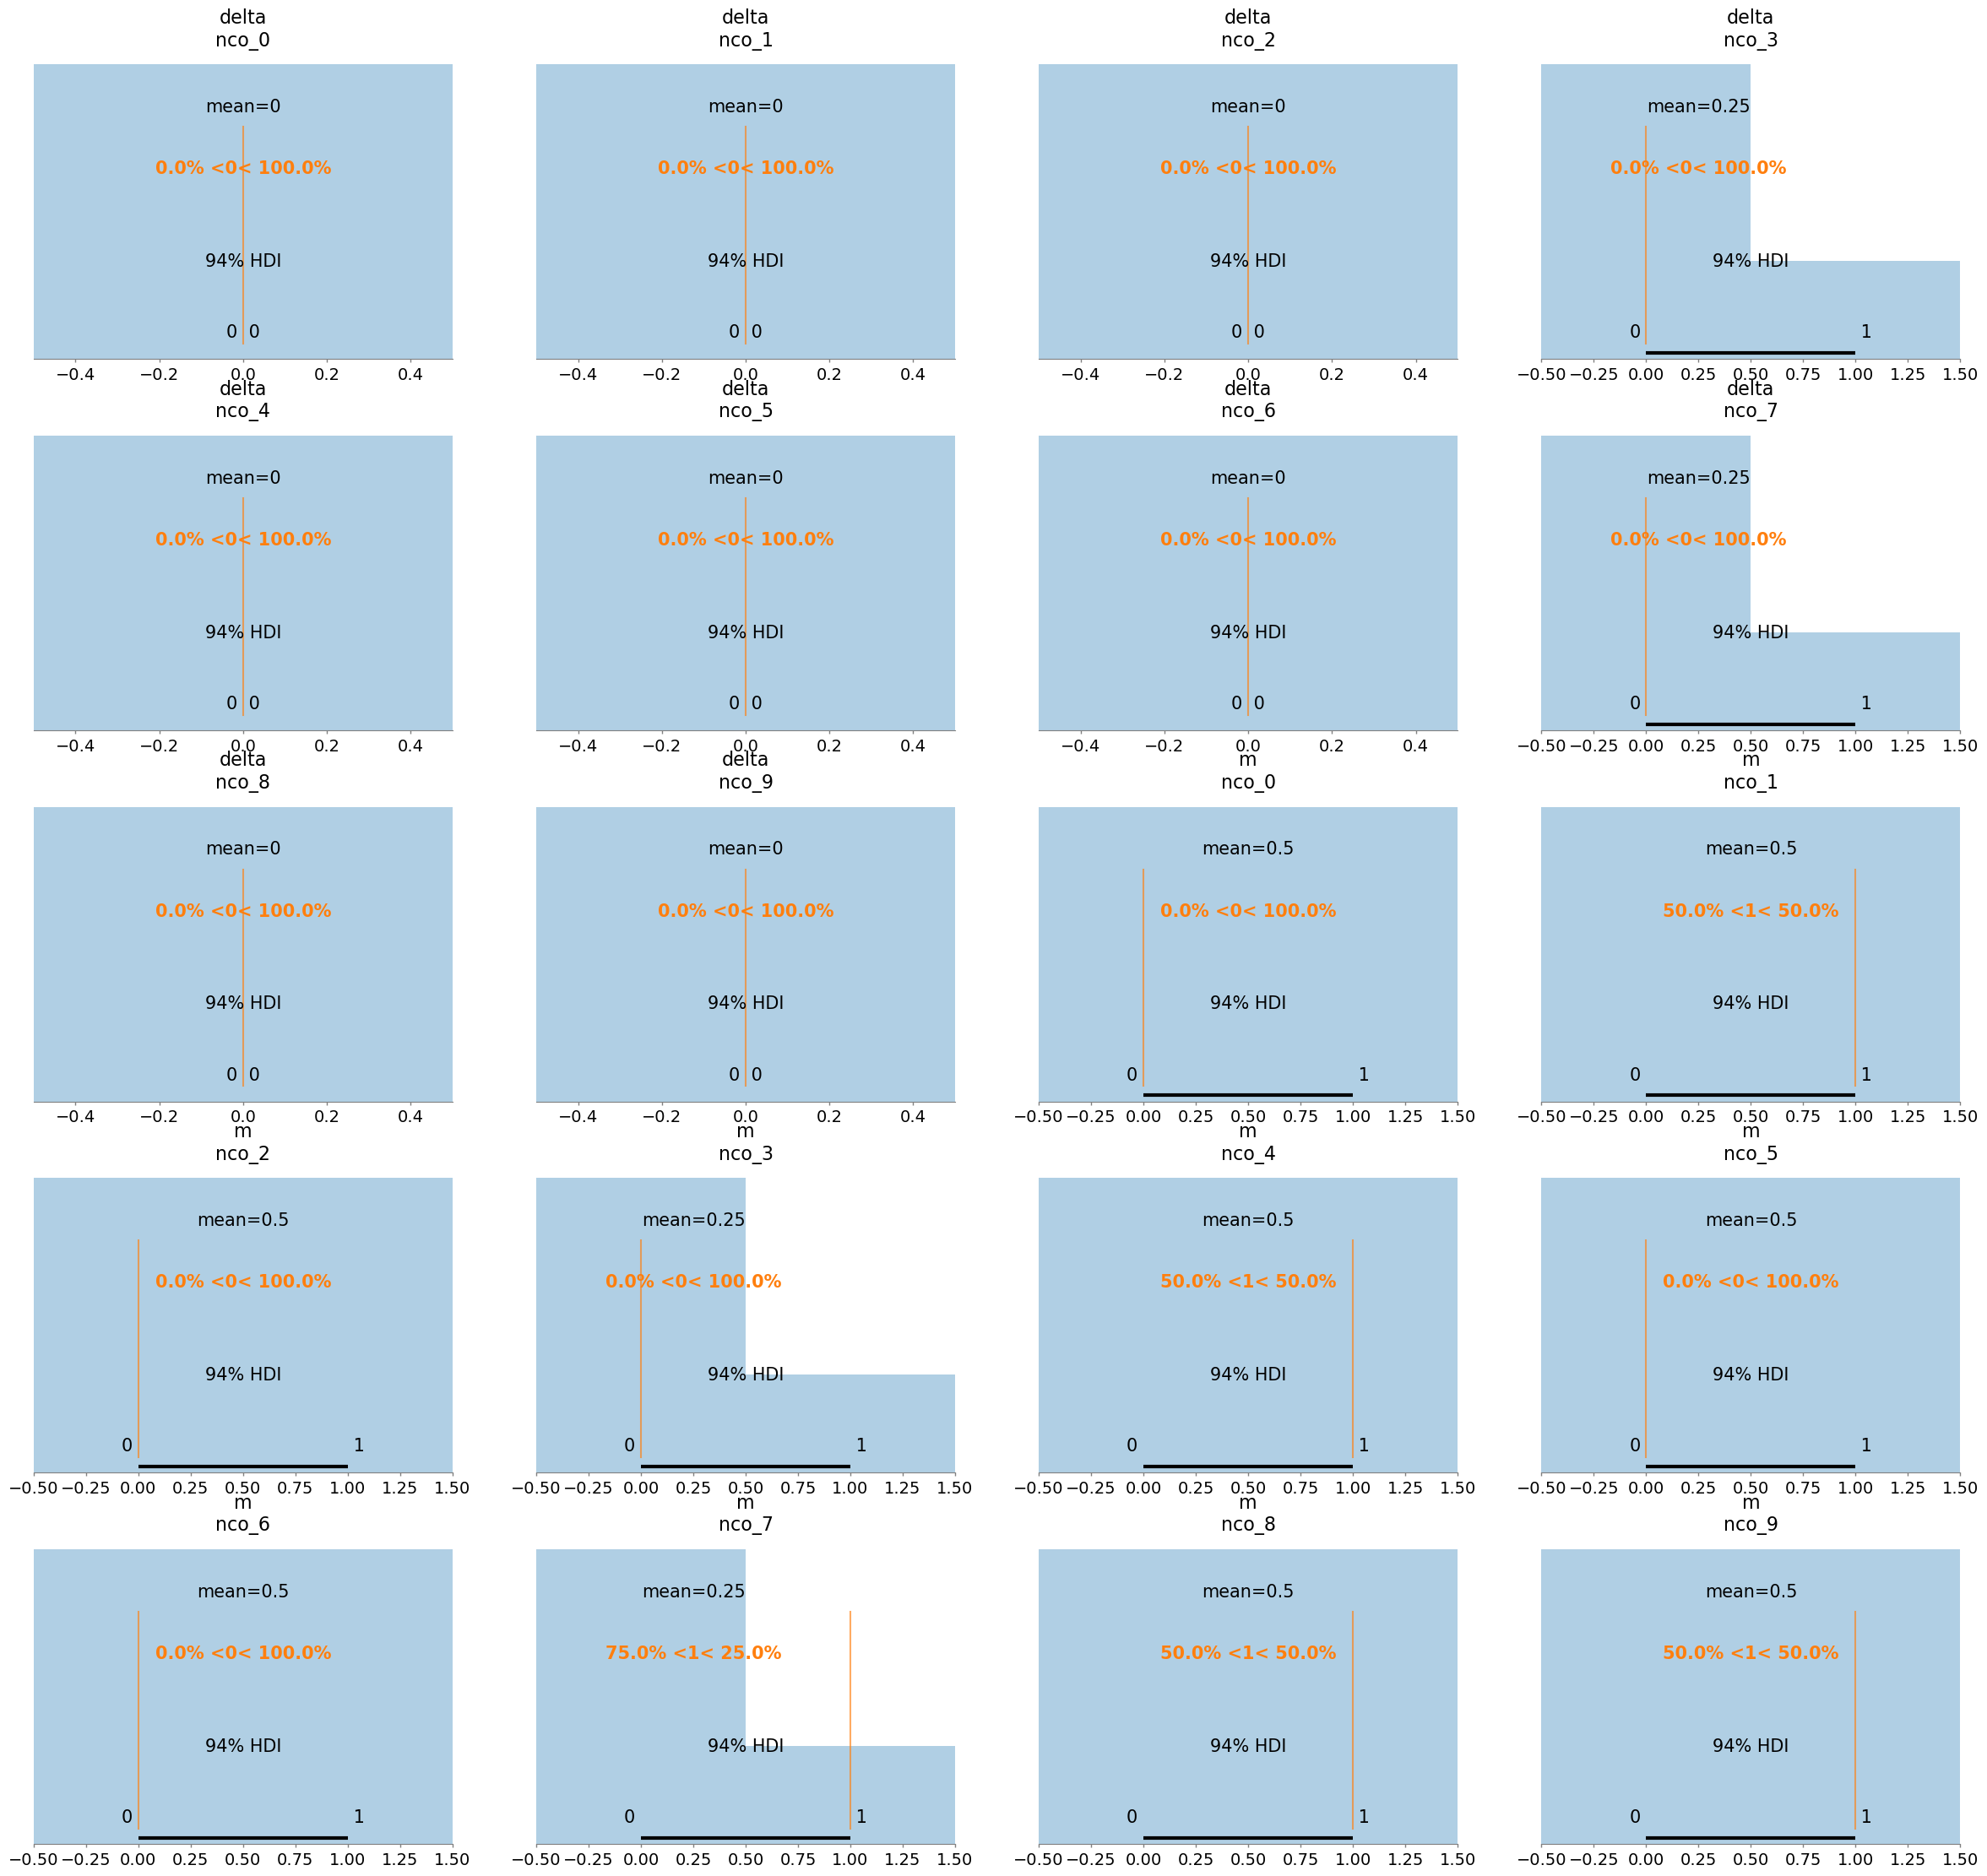

In [328]:
# Diagnose convergence by plotting posterior density and trace plots
az.plot_trace(trace_in, var_names=["beta", 'tau', 'sigma', 'delta']); # expected magnitude of the bias in each treatment contrast

# Plot individual posterior density and true values written in orange
az.plot_posterior(trace_in, var_names="beta", ref_val=np.abs(bias_N_true).mean(axis=0).round(2).tolist());
az.plot_posterior(trace_in, var_names=["delta", "m"], ref_val=np.concatenate((true_delta, true_M)).astype(int).tolist());

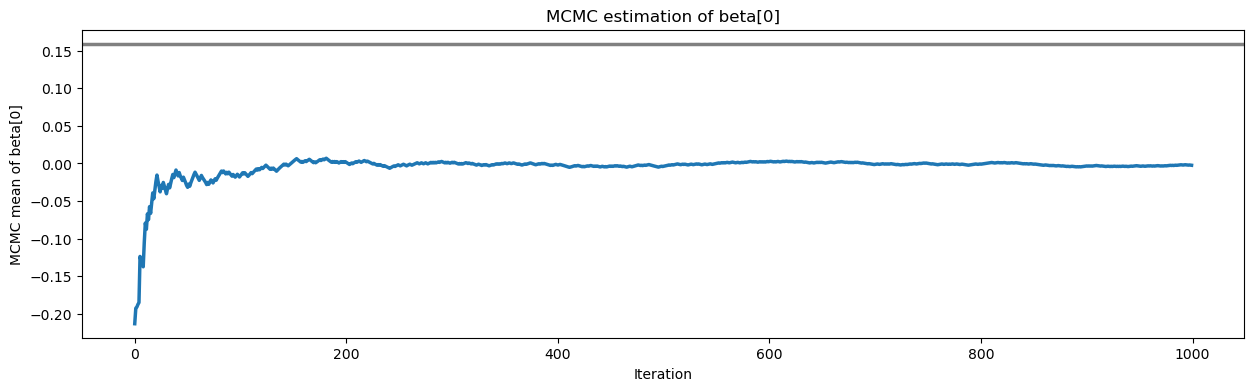

In [325]:
logtau = az.extract(trace_cor, var_names=['beta'], num_samples=1000)
mlogtau = np.cumsum(logtau, axis=1)
plt.figure(figsize=(15, 4))
plt.axhline(true_beta[0], lw=2.5, color="gray")
plt.plot(mlogtau[0,:] / np.arange(1, 1001), lw=2.5)
plt.xlabel("Iteration")
plt.ylabel("MCMC mean of beta[0]")
plt.title("MCMC estimation of beta[0]");

In [168]:
# Plot posterior of the biases for each NCOs
axes = az.plot_posterior(trace_cor, var_names="mu", ref_val=bias_N_true.round(2).flatten().tolist());
for ax, m, se in zip(axes.flatten(), bias_N.flatten(), se_bias_N.flatten()):
    ax.axvline(x=m, color='gray')
    ax.axvline(x=(m-1.96*se), ls='--', color='gray')
    ax.axvline(x=(m+1.96*se), ls='--', color='gray')

ValueError: Image size of 1767x130546 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2208x5520 with 30 Axes>

#### Mixture model parametrization

In [332]:
model_mix= get_model_mixture(bias_N, se_bias_N, alpha_d=1, beta_d=10, alpha_m=5, beta_m=5)
with model_mix:
    # MCMC sampling
    trace_mix = pm.sample(n_samples, tune=n_tune, chains=n_chains, target_accept=0.9, random_seed=RANDOM_SEED)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [nu, tau, phi_d, phi_m, beta, sigma, slap]
>BinaryGibbsMetropolis: [m]


Sampling 4 chains for 20_000 tune and 2_000 draw iterations (80_000 + 8_000 draws total) took 293 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 746 divergences after tuning. Increase `target_accept` or reparameterize.


In [255]:
# Convergence diagnostics, requires multiple chains
az.summary(trace_mix, var_names=['beta', 'tau', 'sigma', 'nu']).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[setting_0],-0.08,0.14,-0.19,0.19,0.07,0.05,7.0,26.0,1.53
beta[setting_1],-0.14,0.25,-0.32,0.30,0.12,0.10,7.0,31.0,1.53
beta[setting_2],-0.06,0.12,-0.15,0.15,0.06,0.04,7.0,25.0,1.53
tau,0.23,0.30,0.03,0.62,0.01,0.01,892.0,1621.0,1.00
sigma[setting_0],0.02,0.02,0.00,0.05,0.00,0.00,311.0,244.0,1.01
sigma[setting_1],0.03,0.02,0.00,0.06,0.00,0.00,209.0,107.0,1.02
sigma[setting_2],0.02,0.01,0.00,0.04,0.00,0.00,186.0,178.0,1.03


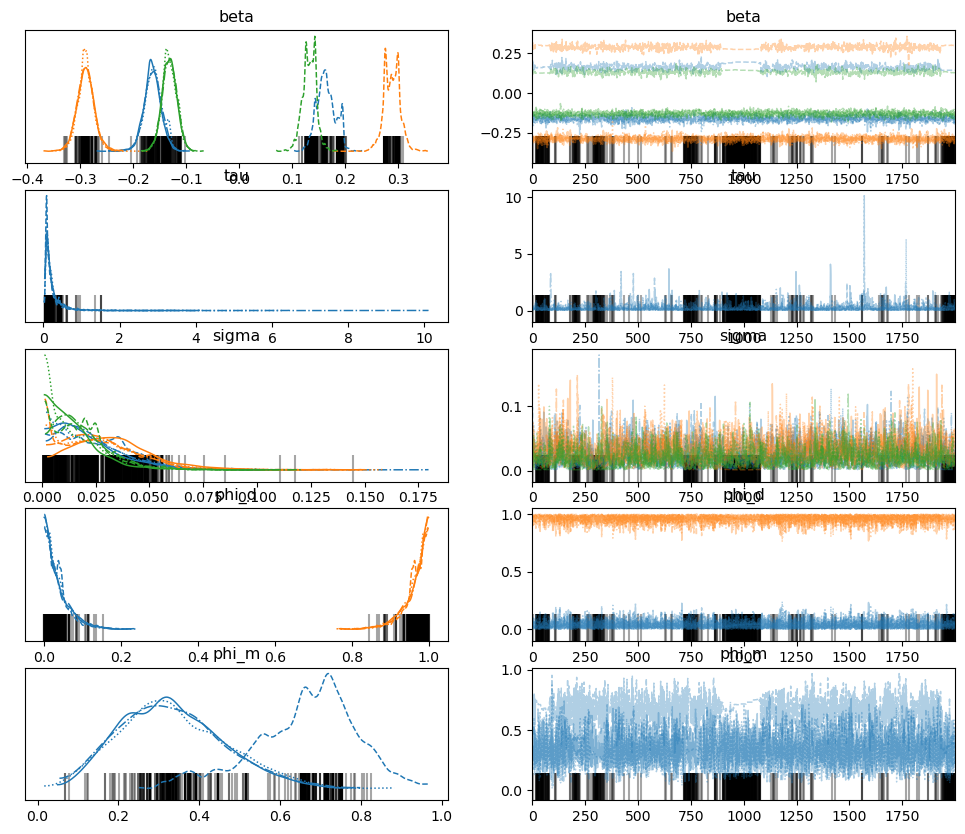

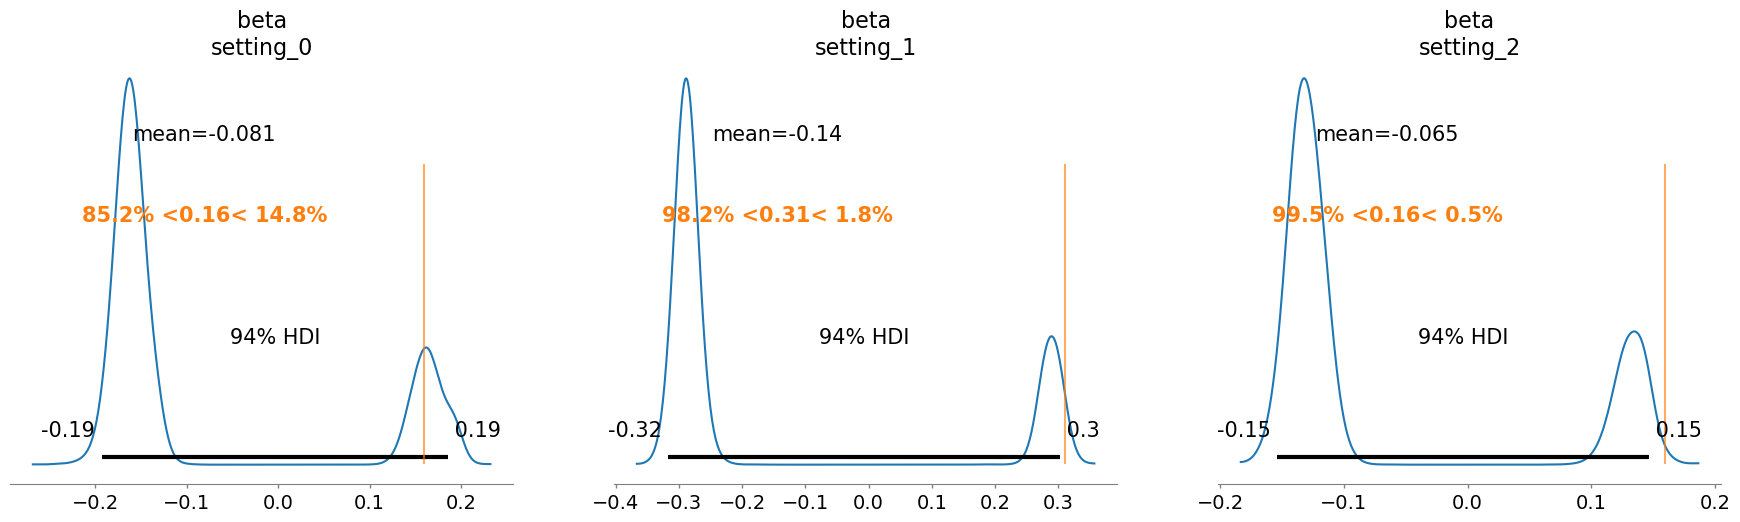

In [256]:
# Diagnose convergence by plotting posterior density and trace plots
az.plot_trace(trace_mix, var_names=["beta", "tau", "sigma", "phi_d", 'phi_m']); # expected magnitude of the bias in each treatment contrast

# Plot individual posterior density and true values written in orange
az.plot_posterior(trace_mix, var_names="beta", ref_val=np.abs(bias_N_true).mean(axis=0).round(2).tolist());

In [111]:
# ate: I \times K matrix of ATE estimates
# se: I \times K matrix of s.e. of the ATE estimates
# phi_d, phi_m: Empirical Bayes estimates of phi_d, phi_m; if None places hierarchical priors on them
# TODO: update code to take se as covariance matrix inputs
def get_model_mixture(ate, se, x=None, phi_d=None, phi_m=None, nu=None, tau=None, alpha_d=1, beta_d=1, alpha_m=1, beta_m=1):
    # Set the number of NCOs
    I = ate.shape[0]
    
    # Set the number of scenarios/treatment contrasts
    K = ate.shape[1]

    # Declare the dimensions of the data and parameters. 
    # This helps with organizing the indices of the posterior samples
    coords_nco = ['nco_'+str(i) for i in range(I)]
    coords_setting = ['setting_'+str(i) for i in range(K)]
    coords = {'nco': coords_nco, 'setting': coords_setting}
    
    # Initialize a model
    model = pm.Model(coords=coords)
    with model:
        
        # State input data as shared variables. Not sure if this is neccesary, but seems to be recommended in the documentation
        Y_t = pm.MutableData('Y', ate, dims=('nco', 'setting'))
        Sigma_t = pm.MutableData('Sigma', se, dims=('nco', 'setting')) # TODO: update to include covariances
        x_t = pt.ones(I) #pm.MutableData('x', x, dims='nco') # currently fix to a vector of ones for group-mean estimation

        # Priors for unknown model parameters
        if nu is None:
            nu_t = pm.Normal('nu', mu=0, sigma=100)
        else:
            nu_t = nu
        if tau is None:
            tau_t = pm.HalfCauchy('tau', beta=1)
        else:
            tau_t = tau
        if phi_d is None: 
            phi_d_t = pm.Dirichlet('phi_d', a=np.array([1, 1]), shape=(2,))  # 2 mixture weights
        else:
            phi_d_t = phi_d
        if phi_m is None: 
            phi_m_t = pm.Beta('phi_m', alpha=alpha_m, beta=beta_m)
        else:
            phi_m_t = phi_m
        beta_t = pm.Normal('beta', mu=nu_t, sigma=tau_t, size=K, dims='setting')
        sigma_t = pm.HalfCauchy('sigma', beta=1, size=K, dims='setting')
        m_t = pm.Bernoulli('m', p=phi_m_t, size=I, dims='nco')
        slap_t = pm.Normal('slap', mu=pt.outer((2*m_t-1), beta_t), sigma=pt.outer(pt.ones(I), sigma_t), dims=('nco', 'setting'))

        # As we just need the logp, rather than add a RV to the model, we need to call `.dist()`
        # Define mixture component for the mean bias
        components = [
            pm.Normal.dist(mu=0, sigma=Sigma_t, shape=(I, K)),
            pm.Normal.dist(mu=slap_t, sigma=Sigma_t, shape=(I, K))
        ]

        # TODO: make this a truncated likelihood -2 to 2?
        # Mixture likelihood model: each element in the (I, K) matrix is sampled from a mixture of two Normals as defined in 'components'
        Y_obs = pm.Mixture('Y_obs', w=phi_d_t, comp_dists=components, observed=Y_t)

        # # Compound sampling step using MH + MWG + NUTS
        # if (mh_step):
        #     step = pm.CompoundStep([
        #                             pm.BinaryGibbsMetropolis([delta_t, m_t], transit_p=.42),
        #                             pm.Metropolis([beta_t, slap_t, sigma_t, tau_t])
        #                             ])
        #     return (model, step)
    
    return model

In [335]:
# Predict the bias in Y, assuming we expect both A and U have protective effect on Y => M=1
# For each MCMC iteration: simulate \delta_Y| \phi_d => S_Yk|\delta_Y, \beta_k, \sigma_k for all K => ATE = ATE_obs - S_Yk
samps_in = az.extract(trace_in, var_names=['beta', 'sigma'], num_samples=num_samps).to_dataframe()
samps_in = samps_in.drop(['draw', 'chain'], axis=1)
samps_in = samps_in.reset_index()
samps_in.sort_values(by=['chain', 'draw', 'setting'], inplace=True)
samps_in['phi_d'] = 0.1
samps_in['delta_y'] = np.repeat(np.random.binomial(1, samps_in.groupby(['draw', 'chain'])['phi_d'].min()), K)
samps_in['slap_y'] = np.random.normal(np.abs(samps_in['beta']), samps_in['sigma'], len(samps_in))
samps_in['bias_posterior'] = (1-samps_in['delta_y'])*samps_in['slap_y']
samps_in['bias_y_obs'] = np.tile(ate_Y_obs - ate_Y, num_samps)
print(samps_in.head(3))


        setting  chain  draw      beta     sigma  phi_d  delta_y    slap_y  \
99    setting_0      0     2 -0.172444  0.012960    0.1        0  0.180709   
1099  setting_1      0     2 -0.299852  0.027700    0.1        0  0.321992   
2099  setting_2      0     2 -0.121769  0.002592    0.1        0  0.123215   

      bias_posterior  bias_y_obs  
99          0.180709    0.169544  
1099        0.321992    0.330087  
2099        0.123215    0.160542  


In [340]:
samps_mix = az.extract(trace_mix, var_names=["phi_d", 'beta', 'sigma'], num_samples=num_samps).to_dataframe()
samps_mix = samps_mix.drop(['draw', 'chain'], axis=1)
samps_mix = samps_mix.reset_index()
samps_mix = samps_mix[samps_mix.phi_d_dim_0 == 0]
samps_mix.sort_values(by=['chain', 'draw', 'setting'], inplace=True)
samps_mix['delta_y'] = np.repeat(np.random.binomial(1, samps_mix.groupby(['draw', 'chain'])['phi_d'].min()), K)
samps_mix['slap_y'] = np.random.normal(np.abs(samps_mix['beta']), samps_mix['sigma'], len(samps_hp))
samps_mix['bias_posterior'] = (1-samps_mix['delta_y'])*samps_mix['slap_y']
samps_mix['bias_y_obs'] = np.tile(ate_Y_obs - ate_Y, num_samps)
print(samps_mix.head(3))

     phi_d_dim_0  chain  draw    setting     phi_d      beta     sigma  \
939            0      0     5  setting_0  0.002615 -0.154573  0.008770   
940            0      0     5  setting_1  0.002615 -0.311852  0.022620   
941            0      0     5  setting_2  0.002615 -0.112763  0.005401   

     delta_y    slap_y  bias_posterior  bias_y_obs  
939        0  0.136981        0.136981    0.169544  
940        0  0.290203        0.290203    0.330087  
941        0  0.115942        0.115942    0.160542  
